## popol_project_modeling

### 1.import

In [45]:
import os
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

### 2.데이터셋 클래스 정의

In [52]:
# MediaPipe 손 모델 초기화
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)

class HandDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found at path: {image_path}")
        
        if idx >= len(self.image_paths):
            raise IndexError(f"Index {idx} out of range")
        
        image = cv2.imread(self.image_paths[idx])
        if image is None:
            raise FileNotFoundError(f"Image not fount at path: {self.image_paths[idx]}")
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = hands.process(image)
        
        # 초기 랜드마크와 손 종류를 None으로 설정
        landmarks_left, landmarks_right = None, None
        label_left, label_right = -1, -1
        
        if results.multi_hand_landmarks:
            for hand_landmarks, handedness in zip(results.multi_hand_landmarks, results.multi_handedness):
                landmarks = [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark]
                landmarks = torch.tensor(landmarks).flatten()
                
                hand_state = self.get_hand_state(landmarks)
                
                if handedness.classification[0].label == "Left":
                    landmarks_left = landmarks
                    label_left = 0 if hand_state == "open_hand" else 1
                    
                else:
                    landmarks_right = landmarks
                    label_right = 2 if hand_state == "open_hand" else 3
        
        # 왼손 또는 오른손 랜드마크가 없는 경우, 0으로 채움            
        if landmarks_left is None:
            landmarks_left = torch.zeros(63)
        if landmarks_right is None:
            landmarks_right = torch.zeros(63)
        
        # 라벨이 설정되지 않은 경우, -1로 설정
        if label_left == -1:
            label_left = 4 # 이는 "왼손 없음"을 의미할 수 있음
        if label_right == -1:
            label_right = 4 # 이는 "오른손 없음"을 의미할 수 있음
            
        label_left = torch.tensor(label_left, dtype=torch.long)
        label_right = torch.tensor(label_right, dtype=torch.long)
            
        return landmarks_left, label_left, landmarks_right, label_right
            
    def get_hand_state(slef, landmarks):
        # 각 손가락의 끝점과 중간점 사이의 거리를 계산하여 손가락이 구부러졌는지 판단
        finger_tips = [4, 8, 12, 20] # 엄지, 집게손가락, 중지, 새끼손가락 끝점 랜드마크 인덱스
        finger_middels = [3, 7, 11, 19] # 엄지, 집게손가락, 중지, 새끼손가락 중간점 랜드마크 인덱스
        closed_count = 0
        
        for tip, middle in zip(finger_tips, finger_middels):
            # tip_pos와 middle_pos는 각각 (x, y, z) 좌표를 가진 텐서
            tip_pos = landmarks[tip * 3:tip * 3 + 3] # x, y, z 좌표 추출
            middle_pos = landmarks[middle * 3:middle * 3 + 3]
            
            # 유클리드 거리 계산
            distance = torch.sqrt(torch.sum((tip_pos - middle_pos) ** 2))
            
            if distance < 0.03: # 실험을 통해 조정
                closed_count += 1
                
        # 대부분의 손가락이 구부러진 것으로 판단되면 손을 쥐었다고 간주
        if closed_count >= 3:
            return "closed_hand"
        else:
            return "open_hand"

### 3.신경망 모델, 손실 함수, 최적화 방법 정의

In [ ]:
class HandStateCNN(nn.Module):
    def __init__(self, n_classes):
        super(HandStateCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # 입력 채널 수는 이미지가 grayscale인지 RGB인지에 따라 달라질 수 있습니다.
            # 여기서는 RGB 이미지를 가정합니다. Grayscale의 경우, in_channels=1로 설정하세요.
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * (image_size // 8) * (image_size // 8), 512),  # image_size는 이미지의 가로 또는 세로 크기입니다.
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, n_classes),
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x
    
    # 모델 아키텍처 정의
# class HandStateNN(nn.Module):
#     def __init__(self, n_classes):
#         super(HandStateNN, self).__init__()
#         self.network = nn.Sequential(
#             nn.Linear(63, 256), 
#             nn.ReLU(),
#             nn.BatchNorm1d(256),
#             nn.Dropout(0.1),
            
#             # nn.Linear(256, 512),
#             # nn.ReLU(),
#             # nn.BatchNorm1d(512),
#             # nn.Dropout(0.1),
            
#             # nn.Linear(512, 256),
#             # nn.ReLU(),
#             # nn.BatchNorm1d(256),
#             # nn.Dropout(0.1),
            
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.BatchNorm1d(128),
#             nn.Dropout(0.1),
            
#             nn.Linear(128, 64),
#             nn.ReLU(),
            
#             nn.Linear(64, n_classes)
#         )
#     def forward(self, x):
#         return self.network(x)
    
n_classes = 5
batch_size = 16
num_epochs = 30
learning_rate = 0.0001

In [47]:
# 모델 아키텍처 정의
class HandStateNN(nn.Module):
    def __init__(self, n_classes):
        super(HandStateNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(63, 256), 
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.1),
            
            # nn.Linear(256, 512),
            # nn.ReLU(),
            # nn.BatchNorm1d(512),
            # nn.Dropout(0.1),
            
            # nn.Linear(512, 256),
            # nn.ReLU(),
            # nn.BatchNorm1d(256),
            # nn.Dropout(0.1),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            
            nn.Linear(64, n_classes)
        )
    def forward(self, x):
        return self.network(x)
    
n_classes = 5
batch_size = 16
num_epochs = 30
learning_rate = 0.0001

# 데이터 준비
train_image_paths = [os.path.join("../data/train/", img_file) for img_file in os.listdir("../data/train/") if img_file.endswith(".jpg")]
validation_image_paths = [os.path.join("../data/val/", img_file) for img_file in os.listdir("../data/val/") if img_file.endswith(".jpg")]

# 데이터 셋 정의
train_dataset = HandDataset(train_image_paths)
validation_dataset = HandDataset(validation_image_paths)

# 데이터 불러오기
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=8, shuffle=True)

# 모델 초기화
model = HandStateNN(n_classes)

# 손실 함수 및 최적화기 정의
criterion = nn.CrossEntropyLoss() # 내부적으로 softmax 실행
optimizer = optim.Adam(model.parameters(), lr=0.0001)

### 학습 및 검증

In [48]:

# 손실과 정확도를 기록하기 위한 리스트
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

best_val_loss = float("inf")
patience = 5 # 성능이 개선되지 않는 에폭의 최대 허용 수
patience_counter = 0 # 현재 patience 카운터

for epoch in tqdm(range(num_epochs)):
    model.train() # 학습 모드
    train_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    
    for batch in train_dataloader:
        # 배치에서 데이터 추출
        landmarks_left, labels_left, landmarks_right, labels_right = batch
        
        # 왼손에 대한 예측
        preds_left = model(landmarks_left)
        loss_left = criterion(preds_left, labels_left)
        
        # 오른손에 대한 예측
        preds_right = model(landmarks_right)
        loss_right = criterion(preds_right, labels_right)
        
        # 총 손실 계산
        train_loss = loss_left + loss_right
        
        # 역전파 및 최적화
        optimizer.zero_grad() # 기존 그래디언트 초기화
        train_loss.backward()       # 총 손실에 대한 역전파 수행
        optimizer.step()      # 모델 파라미터 업데이트
        
        # 예측된 클래스와 실제 라벨 비교
        _, predicted_left = torch.max(preds_left.data, 1)
        _, predicted_right = torch.max(preds_right.data, 1)
        
        # 정확도 계산
        total_train_predictions += labels_left.size(0) + labels_right.size(0)
        correct_train_predictions += (predicted_left == labels_left).sum().item()
        correct_train_predictions += (predicted_right == labels_right).sum().item()
        
    # 에폭당 평균 손실과 정확도 계산
    avg_train_loss = train_loss / len(train_dataloader)
    train_accuracy = correct_train_predictions / total_train_predictions * 100
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    
    # 검증 루프
    model.eval()  # 평가 모드
    validation_loss = 0.0
    correct_validation_preds = 0
    total_validation_preds = 0

    with torch.no_grad():
        # 검증 데이터셋에 대한 루프
        for batch in validation_loader:
            landmarks_left, labels_left, landmarks_right, labels_right = batch
            
            # 왼손에 대한 예측
            preds_left = model(landmarks_left)
            loss_left = criterion(preds_left, labels_left)

            # 오른손에 대한 예측
            preds_right = model(landmarks_right)
            loss_right = criterion(preds_right, labels_right)

            # 총 손실 계산
            validation_loss += loss_left.item() + loss_right.item()

            # 예측된 클래스와 실제 라벨 비교
            _, predicted_left = torch.max(preds_left.data, 1)
            _, predicted_right = torch.max(preds_right.data, 1)

            # 정확도 계산
            total_validation_preds += labels_left.size(0) + labels_right.size(0)
            correct_validation_preds += (predicted_left == labels_left).sum().item()
            correct_validation_preds += (predicted_right == labels_right).sum().item()

    # 에폭당 평균 손실과 정확도 계산
    avg_validation_loss = validation_loss / len(validation_loader)
    validation_accuracy = (correct_validation_preds / total_validation_preds) * 100
    validation_losses.append(avg_validation_loss)
    validation_accuracies.append(validation_accuracy)
    
    # Early Stopping 검사
    if avg_validation_loss < best_val_loss:
        best_val_loss = avg_validation_loss
        patience_counter = 0 # patience counter 리셋
        # 최적 모델 저장
        # torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break # 학습 중단
    
    # 현재 에폭의 손실과 정확도 출력
    print(f"Epoch {epoch}, train_loss: {avg_train_loss:.4f}, val_loss: {avg_validation_loss:.4f}, train_acc: {train_accuracy:.2f}%, val_acc: {validation_accuracy:.2f}%")

  0%|          | 0/30 [00:00<?, ?it/s]

  3%|▎         | 1/30 [01:34<45:44, 94.65s/it]

Epoch 0, train_loss: 0.0183, val_loss: 1.3018, train_acc: 71.66%, val_acc: 92.52%


  7%|▋         | 2/30 [03:08<44:01, 94.34s/it]

Epoch 1, train_loss: 0.0090, val_loss: 0.7936, train_acc: 90.38%, val_acc: 94.55%


 10%|█         | 3/30 [04:43<42:31, 94.48s/it]

Epoch 2, train_loss: 0.0057, val_loss: 0.6101, train_acc: 93.94%, val_acc: 95.64%


 13%|█▎        | 4/30 [06:18<40:59, 94.61s/it]

Epoch 3, train_loss: 0.0076, val_loss: 0.5446, train_acc: 96.25%, val_acc: 95.17%


 17%|█▋        | 5/30 [07:52<39:18, 94.35s/it]

Epoch 4, train_loss: 0.0101, val_loss: 0.3705, train_acc: 97.07%, val_acc: 96.73%


 20%|██        | 6/30 [09:28<37:57, 94.90s/it]

Epoch 5, train_loss: 0.0106, val_loss: 0.3285, train_acc: 96.64%, val_acc: 97.20%


 23%|██▎       | 7/30 [11:03<36:30, 95.22s/it]

Epoch 6, train_loss: 0.0060, val_loss: 0.3631, train_acc: 96.95%, val_acc: 96.11%


 27%|██▋       | 8/30 [12:38<34:51, 95.05s/it]

Epoch 7, train_loss: 0.0044, val_loss: 0.2673, train_acc: 96.76%, val_acc: 97.66%


 30%|███       | 9/30 [14:14<33:18, 95.18s/it]

Epoch 8, train_loss: 0.0008, val_loss: 0.3411, train_acc: 97.19%, val_acc: 96.73%


 33%|███▎      | 10/30 [15:48<31:40, 95.01s/it]

Epoch 9, train_loss: 0.0055, val_loss: 0.2835, train_acc: 97.34%, val_acc: 97.98%


 37%|███▋      | 11/30 [17:23<30:06, 95.05s/it]

Epoch 10, train_loss: 0.0049, val_loss: 0.3321, train_acc: 97.30%, val_acc: 97.51%


 40%|████      | 12/30 [18:58<28:30, 95.02s/it]

Epoch 11, train_loss: 0.0033, val_loss: 0.3350, train_acc: 97.38%, val_acc: 97.04%


 40%|████      | 12/30 [20:32<30:49, 102.74s/it]

Early stopping triggered


In [49]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 예측과 레이블을 저장할 리스트
all_labels = []
all_preds = []

# 검증 데이터에 대한 예측 수행
model.eval() # 모델을 평가 모드로 설정
with torch.no_grad():
    for bath in validation_loader:
        landmarks_left, labels_left, landmarks_right, labels_right = batch
        
        # 왼손과 오른손 예측
        preds_left = model(landmarks_left)
        preds_right = model(landmarks_right)
        
        # 예측 값 저장
        all_labels.extend(labels_left.tolist())
        all_labels.extend(labels_right.tolist())
        
        # 가장 높은 확률을 가진 클래스 선택
        all_preds.extend(preds_left.argmax(dim=1).tolist())
        all_preds.extend(preds_right.argmax(dim=1).tolist())
        
# 왼손에 대한 confusion matrix와 f1_score 계산
conf_matrix = confusion_matrix(all_labels, all_preds)
f1_score_overall = f1_score(all_labels, all_preds, average='weighted')

# Confusion matrix 정규화
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

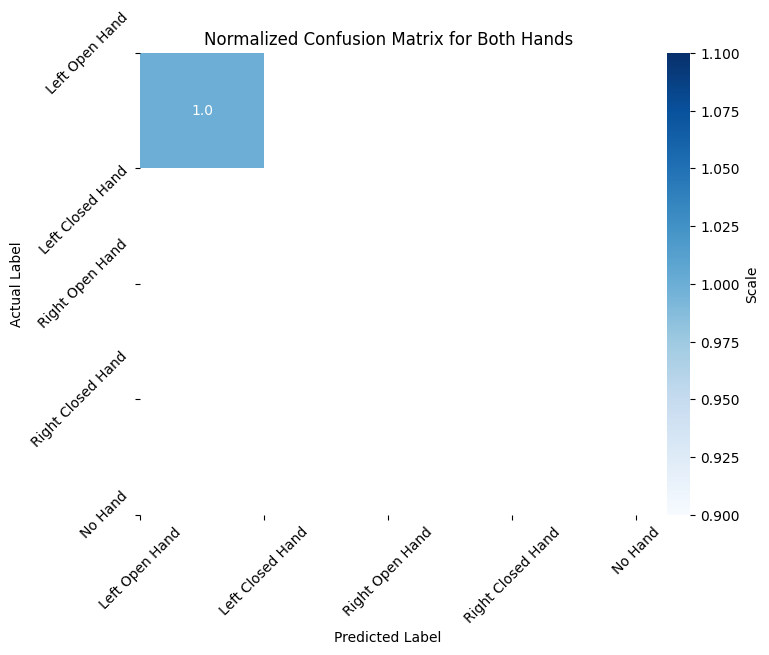

/var/folders/nc/lry6d8ws417_mblykm_8wpc40000gn/T/ipykernel_5101/2408539606.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=f1_score_overall, palette='viridis')


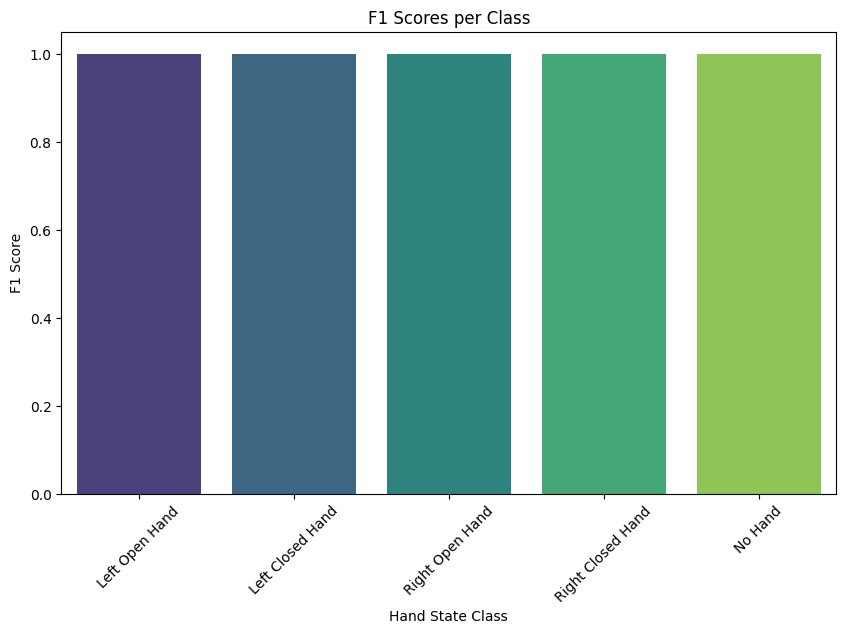

In [50]:
# 클래스 이름
classes = ['Left Open Hand', 'Left Closed Hand', 'Right Open Hand', 'Right Closed Hand', 'No Hand']

# Confusion matrix를 정규화합니다.
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# 정규화된 confusion matrix를 시각화합니다.
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.1f', cmap='Blues', cbar_kws={'label': 'Scale'})
plt.title('Normalized Confusion Matrix for Both Hands')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks(ticks=np.arange(len(classes)), labels=classes, rotation=45)
plt.yticks(ticks=np.arange(len(classes)), labels=classes, rotation=45)
plt.show()


# F1 Score 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=classes, y=f1_score_overall, palette='viridis')
plt.title('F1 Scores per Class')
plt.ylabel('F1 Score')
plt.xlabel('Hand State Class')
plt.xticks(rotation=45) # 클래스 이름이 길어서 라벨을 회전시킴
plt.show()

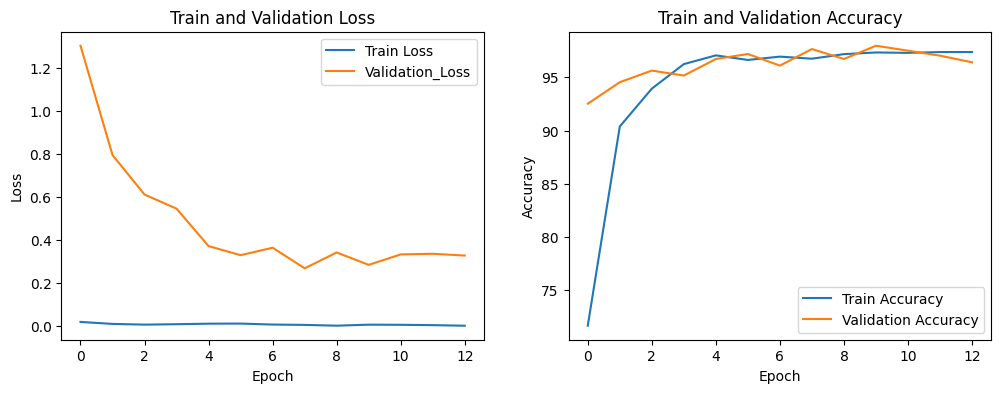

In [51]:
# 리스트의 각 텐서를 numpy 배열로 변환
train_losses_np = [loss.detach().numpy() for loss in train_losses]

# 손실 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses_np, label="Train Loss")
plt.plot(validation_losses, label="Validation_Loss")
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 모델 저장

In [16]:
model_save_path = "trained_model.path"
torch.save(model.state_dict(), model_save_path)